In [1]:
import pickle
import os
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

def scale_data_and_get_pipeline(df, save_path=None):
    """
    Takes the dataframe, Scales numeric features using MinMaxScaler and returns the scaled df, 
    the pipeline, and the list of numeric feature names. Optionally saves the pipeline.
    """
    numeric_features = df.select_dtypes(include=np.number).columns.tolist()
    
    # Pipeline to scale only numeric features
    preprocessor = ColumnTransformer(
        transformers=[('num', MinMaxScaler(), numeric_features)],
        remainder='drop'  # Only keep scaled numeric columns from this pipeline
    )
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    
    # Fit the pipeline and transform the data
    scaled_numeric_data = pipeline.fit_transform(df)
    
    # Create DataFrame for the scaled numeric data
    df_numeric_scaled = pd.DataFrame(
        scaled_numeric_data,
        columns=numeric_features,
        index=df.index
    )
    
    # Save the pipeline if path is provided
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        with open(save_path, 'wb') as f:
            pickle.dump(pipeline, f)
            
    return df_numeric_scaled, pipeline, numeric_features

In [2]:
DATA_PATH = "../raw_data/merged_country_level/final_merged_dataset_with_knn.csv"
df = pd.read_csv(DATA_PATH)
df.shape
df.head()

,Unnamed: 0,average_monthly_cost_$,average_yearly_temperature,internet_speed_mbps,safety_index,Healthcare Index
0,afghanistan,960.545000,18.1,3.880000,24.9,24.24
1,albania,518.916429,22.2,81.410000,55.3,48.21
2,algeria,356.045500,22.8,16.540000,47.4,54.43
3,andorra,1257.460000,11.1,113.413333,84.7,75.56
4,angola,740.635000,27.1,22.910000,33.7,36.58


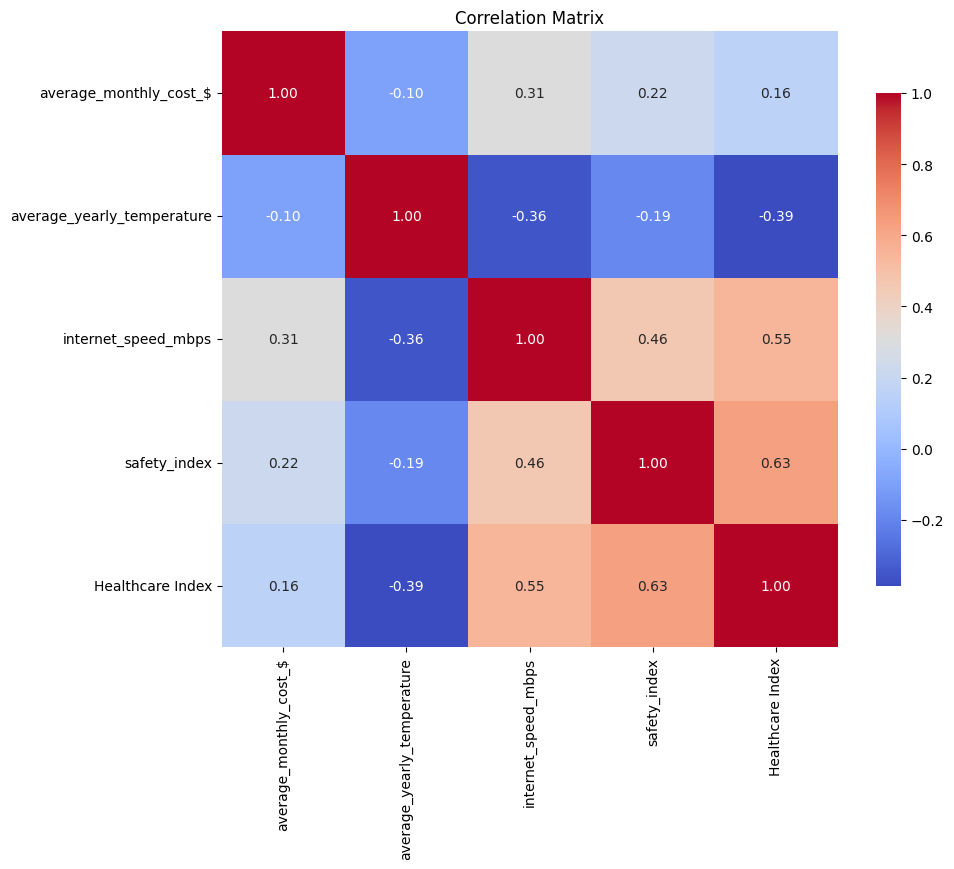

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

num_df = df[['average_monthly_cost_$', 'average_yearly_temperature', 'internet_speed_mbps', 'safety_index', 'Healthcare Index']]

correlation_matrix = num_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Set the title
plt.title('Correlation Matrix')

# Show the plot
plt.show()

In [4]:
from scipy.stats import pearsonr

# Example: testing correlation between cost and healthcare index
corr, p_value = pearsonr(df["internet_speed_mbps"], df["Healthcare Index"])
print(f"Correlation: {corr:.2f}, p-value: {p_value:.4f}")


Correlation: 0.55, p-value: 0.0000


### Lets' try with the scaled dataset

In [5]:

df_scaled, pipeline, numeric_features = scale_data_and_get_pipeline(df)
df_scaled

,average_monthly_cost_$,average_yearly_temperature,internet_speed_mbps,safety_index,Healthcare Index
0,0.111708,0.546926,0.001900,0.085627,0.006066
1,0.044422,0.679612,0.228530,0.550459,0.388729
2,0.019607,0.699029,0.038907,0.429664,0.488027
3,0.156945,0.320388,0.322079,1.000000,0.825351
4,0.078202,0.838188,0.057527,0.220183,0.203065
...,...,...,...,...,...
147,0.052780,0.705502,0.235837,0.000000,0.236750
148,0.047566,0.776699,0.472201,0.610092,0.598020
149,0.073334,0.711974,0.023327,0.259939,0.023148
150,0.070271,0.831715,0.055569,0.536697,0.488186


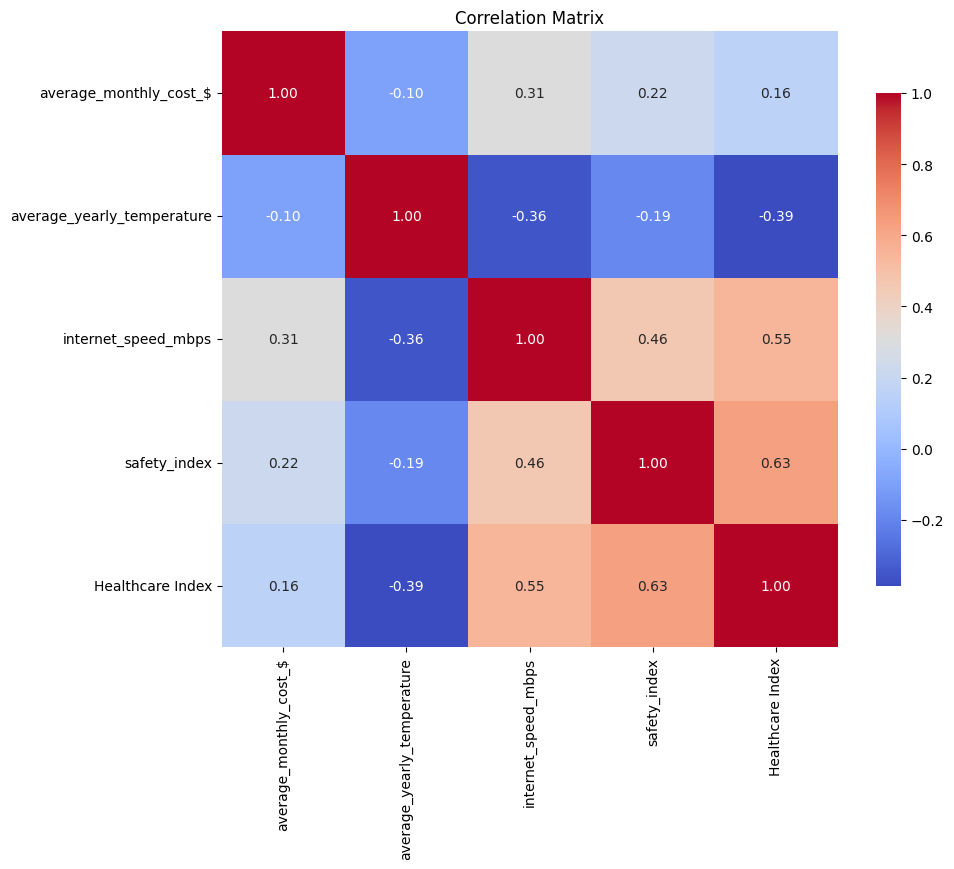

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

num_df_scaled = df_scaled[['average_monthly_cost_$', 'average_yearly_temperature', 'internet_speed_mbps', 'safety_index', 'Healthcare Index']]

correlation_matrix = num_df_scaled.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Set the title
plt.title('Correlation Matrix')

# Show the plot
plt.show()

In [7]:
import pandas as pd
import numpy as np

# Convert all columns to numeric if possible
df = df.apply(pd.to_numeric, errors='coerce')



cols = df.columns
pvals = pd.DataFrame(np.ones((len(cols), len(cols))), columns=cols, index=cols)

for i in cols:
    for j in cols:
        _, p = pearsonr(df[i], df[j])
        pvals.loc[i, j] = p

pvals


,Unnamed: 0,average_monthly_cost_$,average_yearly_temperature,internet_speed_mbps,safety_index,Healthcare Index
Unnamed: 0,NaN,NaN,NaN,NaN,NaN,NaN
average_monthly_cost_$,NaN,0.000000,2.413050e-01,1.103173e-04,6.819389e-03,5.614739e-02
average_yearly_temperature,NaN,0.241305,0.000000e+00,6.193184e-06,1.904211e-02,9.367053e-07
internet_speed_mbps,NaN,0.000110,6.193184e-06,0.000000e+00,2.511103e-09,2.146441e-13
safety_index,NaN,0.006819,1.904211e-02,2.511103e-09,0.000000e+00,2.815917e-18
Healthcare Index,NaN,0.056147,9.367053e-07,2.146441e-13,2.815917e-18,0.000000e+00


In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd
X = df_scaled[[
    "average_monthly_cost_$",
    "average_yearly_temperature",
    "internet_speed_mbps",
    "safety_index",
    "Healthcare Index"
]].copy()

# Add constant for VIF calculation
X = add_constant(X)

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


In [ ]:
df_clustered = pd.read_csv("/Users/federico/code/Brgtt07/project_ics/raw_data/merged_country_level/clustered_countries_labeled.csv")

In [ ]:
df_clustered.head()